In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image
import pytorch_ood
from pytorch_ood.model import WideResNet
import torchattacks
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import tqdm_notebook
import time


### If possible, use CUDA acceleration.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Explore MNIST Dataset
The MNIST dataset contains 60,000 grayscale images of size $28\times28\times1$.

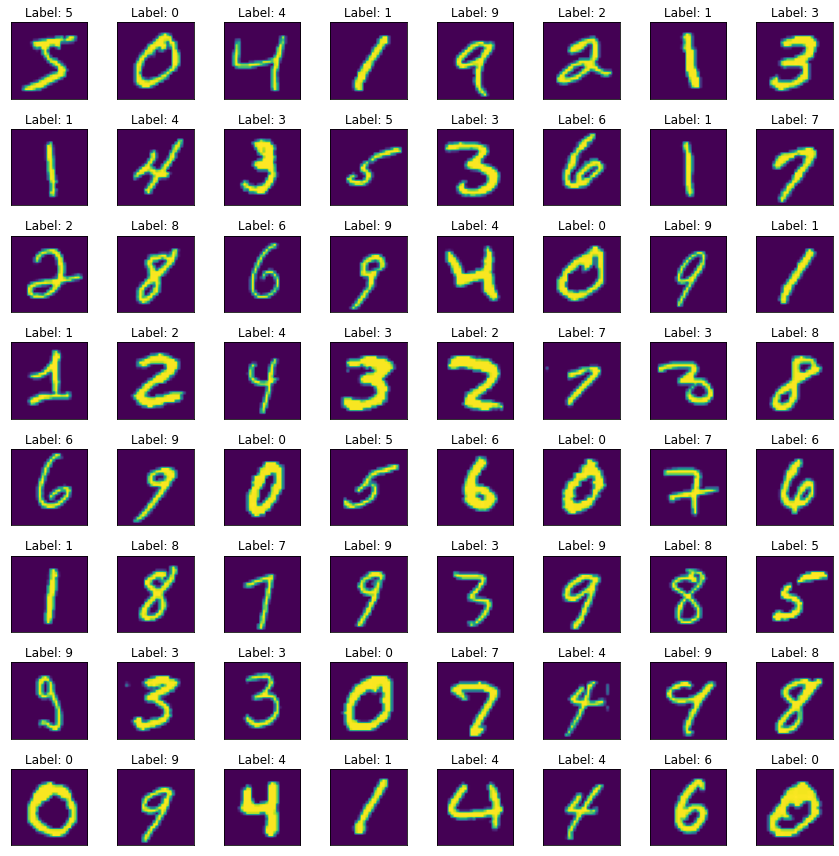

In [3]:
train_ds = datasets.MNIST('MNIST', download=True, train=True)

fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()

for i in range(64):
    x, y = train_ds[i]
    axs[i].imshow(x)
    axs[i].set_title(f"Label: {y}")
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)


plt.tight_layout()
plt.show()

## CIFAR10
The CIFAR10 dataset contains 60,000 RGB images of size $32\times32\times3$.

Files already downloaded and verified


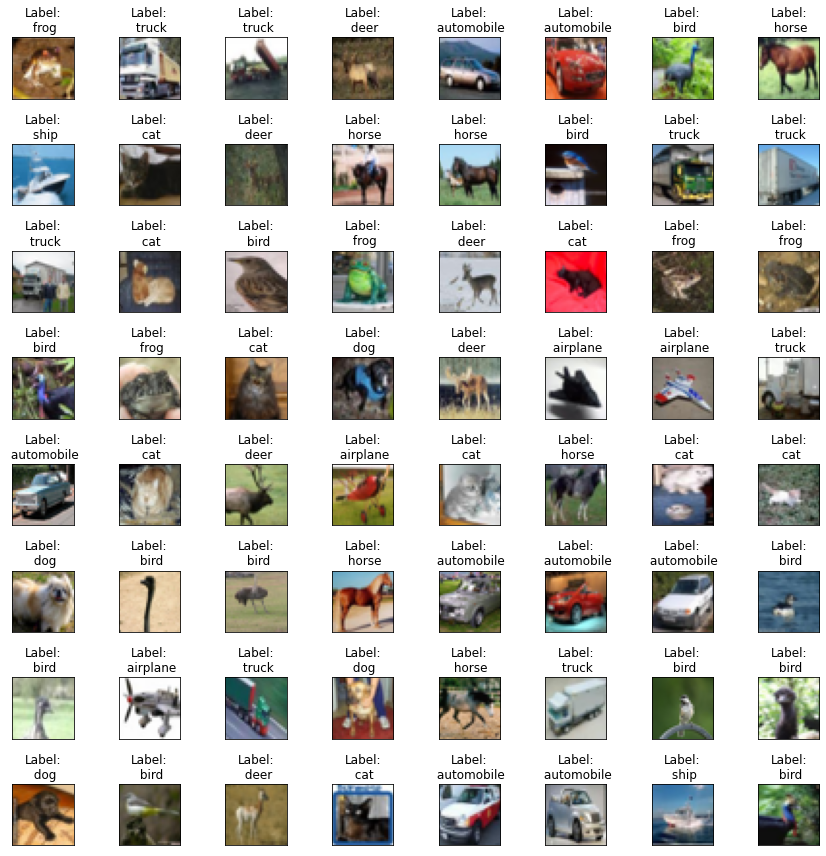

In [4]:
train_ds_cifar = datasets.CIFAR10('CIFAR10', download=True, train=True)
cifar10_labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()

for i in range(64):
    x, y = train_ds_cifar[i]
    axs[i].imshow(x)
    axs[i].set_title(f"Label:\n {cifar10_labels[y]}")
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)


plt.tight_layout()
plt.show()

## Create a Model
Now, lets create a CNN to classify the digits

In [5]:
# LeNet Model definition
class mnist_Net(nn.Module):
    def __init__(self):
        super(mnist_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
# setup transform for MNIST
mnist_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
])


In [7]:
# mnist
mnist_train_ds = datasets.MNIST('MNIST', download=True, train=True, transform=mnist_transform)
mnist_test_ds = datasets.MNIST('MNIST', download=True, train=False, transform=mnist_transform)


mnist_train_loader = torch.utils.data.DataLoader(mnist_train_ds, batch_size=128, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_ds, batch_size=256, shuffle=False)


## Train on the MNIST Training-Set or on the CIFAR10 Training-Set

In [8]:
model = mnist_Net().to(device)

In [9]:
# which data we use to train?
train_loader = mnist_train_loader

# which data we use to test?
test_loader = mnist_test_loader

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# create model and optimizer
opti = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 20

train_losses = []
test_losses = []

def train(epoch):
    model.train() # set model in training mode (need this because of dropout)

    # dataset API gives us pythonic batching
    with tqdm(train_loader, unit="batch") as tepoch:
        for x, y in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            x = x.to(device)
            y = y.to(device)

            # forward pass, calculate loss and backprop!
            opti.zero_grad()
            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y)
            loss.backward()
            opti.step()
            tepoch.set_postfix(loss=loss.item())
        train_losses.append(loss.item())

def test(epoch):
    model.eval() # set model in inference mode (need this because of dropout)
    test_loss = 0
    correct = 0

    with torch.no_grad(): # we do not require gradients
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y)
            pred = y_hat.max(dim=1).indices # get the index of the max log-probability
            correct += pred.eq(y).cpu().sum()
            test_loss += loss

    test_loss /= len(test_loader) # loss function already averages over batch size
    test_losses.append(test_loss.cpu())
    accuracy = correct / len(mnist_test_ds)
    print(f"Test set: Average loss: {loss:.4f}, Accuracy: {correct}/{len(mnist_test_ds)} ({accuracy:.2%})")

start_time = time.time()
for epoch in range(n_epochs):
    
    train(epoch)
    test(epoch)
    
print(f"\n\n Needed {time.time() - start_time} seconds to train the model for {n_epochs} epochs")

Epoch 0: 100%|████████████████████████████████████████████████████████| 469/469 [00:09<00:00, 50.65batch/s, loss=0.167]


Test set: Average loss: 0.0018, Accuracy: 9802/10000 (98.02%)


 Needed 10.249714136123657 seconds to train the model for 1 epochs


## Plot the Learning Process

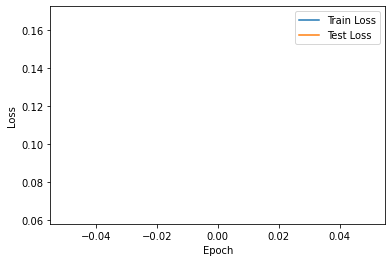

In [13]:
plt.plot(range(n_epochs),train_losses,label = "Train Loss")
plt.plot(range(n_epochs),test_losses, label = "Test Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Test on the MNIST Test-Set
Let's inspect some predictions!

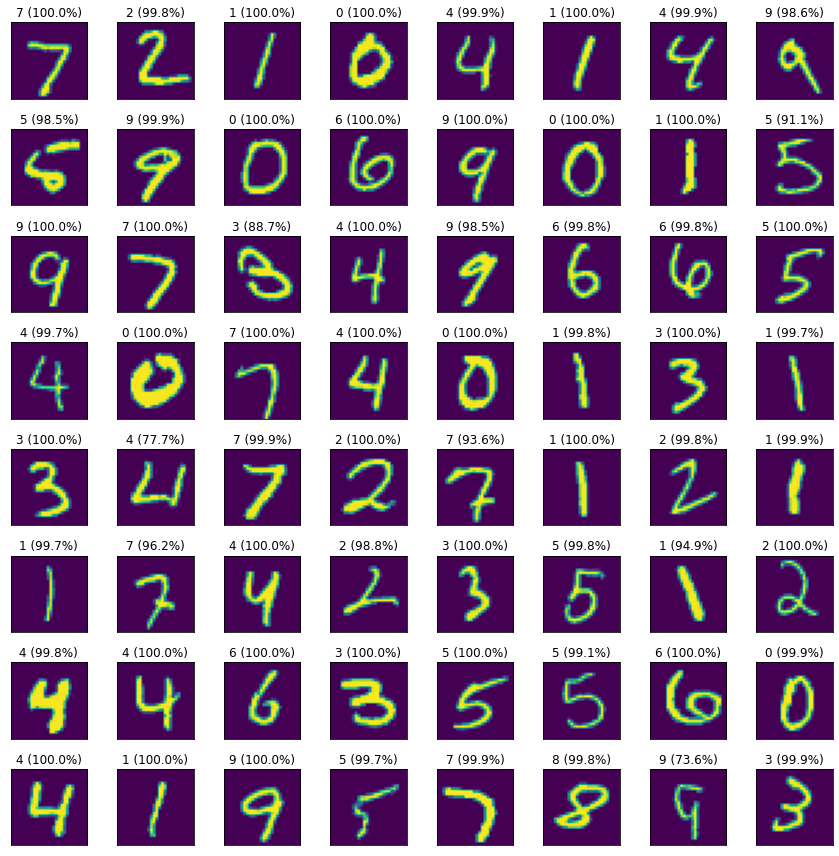

In [14]:
model.eval()

for mnist_images, y in mnist_test_loader:
    with torch.no_grad():
        y_hat = model(mnist_images.to(device))
        break

mnist_values, mnist_indices = y_hat.softmax(dim=1).max(dim=1)
real_vals_mnist = y

# # Softmax Thresholding
# threshold = 0.98
# new_labels = ["Accept" if c > threshold else "Reject" for c in mnist_values]
# colors = ["green" if c > threshold else "red" for c in mnist_values]

fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()

for i in range(64):
    axs[i].imshow(to_pil_image(mnist_images[i]))
    axs[i].set_title(f"{mnist_indices[i]} ({mnist_values[i]:.1%})")
#     axs[i].set_title(f"{new_labels[i]} ({mnist_indices[i]}) \n({mnist_values[i]:.1%})")
#     axs[i].title.set_color(colors[i])
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)
    
plt.tight_layout()
plt.show()

# Outlier Detection

## Test on the KMNIST Test-Set

In [15]:
# define KMNISt dataloader
kmnist_test_ds = datasets.KMNIST('KMNIST', download=True, train=False, transform=mnist_transform)
kmnist_test_loader=torch.utils.data.DataLoader(kmnist_test_ds, batch_size=256, shuffle=False)

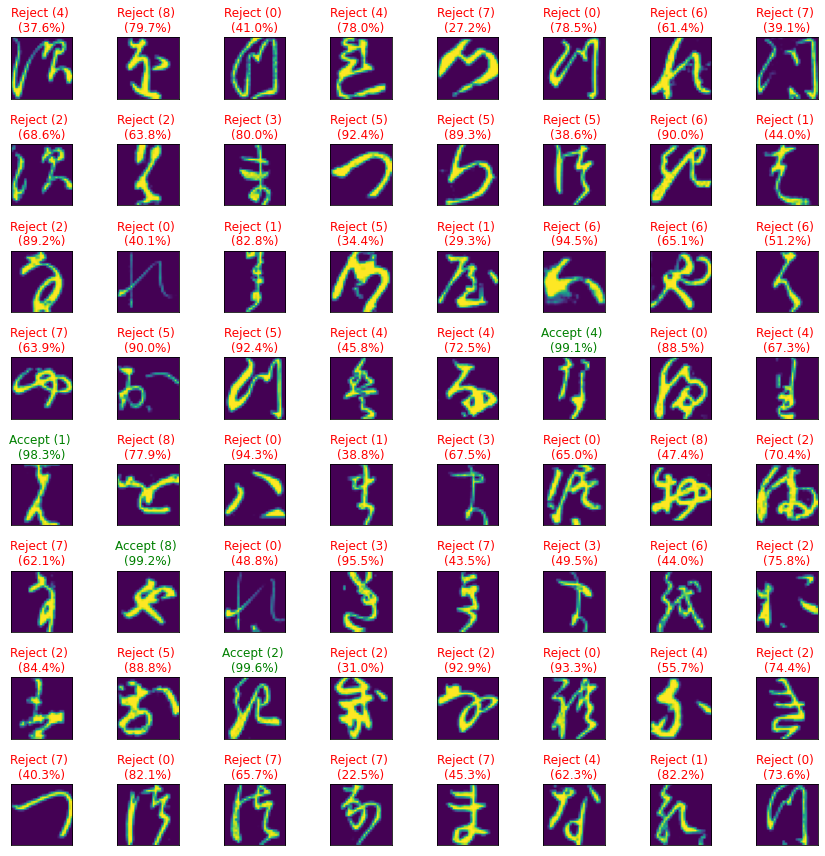

In [16]:
model.eval()

for kmnist_images, y in kmnist_test_loader:
    with torch.no_grad():
        y_hat = model(kmnist_images.to(device))
        break

kmnist_values, kmnist_indices = y_hat.softmax(dim=1).max(dim=1)
real_vals_kmnist = y

# Softmax Thresholding
threshold = 0.98
new_labels = ["Accept" if c > threshold else "Reject" for c in kmnist_values]
colors = ["green" if c > threshold else "red" for c in kmnist_values]

fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()

for i in range(64):
    axs[i].imshow(to_pil_image(kmnist_images[i]))
    #axs[i].set_title(f"{kmnist_indices[i]} ({kmnist_values[i]:.1%})")
    axs[i].set_title(f"{new_labels[i]} ({kmnist_indices[i]}) \n({kmnist_values[i]:.1%})")
    axs[i].title.set_color(colors[i])
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)
    
plt.tight_layout()
plt.show()

## How about CIFAR10?#

## Let's import a pretrained model with around 95% accuracy
Import WideResNet

In [17]:
model_cifar = WideResNet(num_classes=10, pretrained="cifar10-pt")
model_cifar = model_cifar.to(device)

## Create CIFAR10 Datasets

In [18]:
cifar_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
]) 

# cifar10
cifar10_train_ds = datasets.CIFAR10('CIFAR10', download=True, train=True, transform=cifar_transform)
cifar10_test_ds = datasets.CIFAR10('CIFAR10', download=True, train=False, transform=cifar_transform)

cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train_ds, batch_size=128, shuffle=True)
cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_ds, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


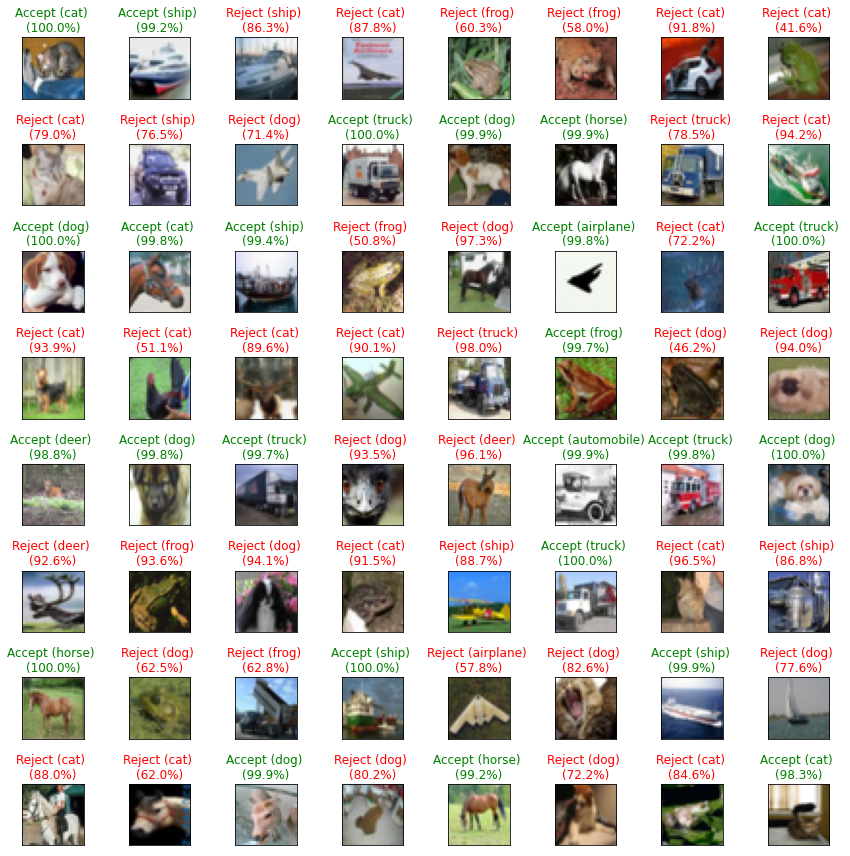

In [19]:
model_cifar.eval()
cifar10_labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
for cifar_images, y in cifar10_test_loader:
    with torch.no_grad():
        y_hat = model_cifar(cifar_images.to(device))
        break

cifar_values, cifar_indices = y_hat.softmax(dim=1).max(dim=1)
real_vals_cifar = y

# Softmax Thresholding
threshold = 0.98
new_labels = ["Accept" if c > threshold else "Reject" for c in cifar_values]
colors = ["green" if c > threshold else "red" for c in cifar_values]

fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()

for i in range(64):
    axs[i].imshow(to_pil_image(cifar_images[i]))
    #axs[i].set_title(f"{cifar10_labels[cifar_indices[i]]} ({cifar_values[i]:.1%})")
    axs[i].set_title(f"{new_labels[i]} ({cifar10_labels[cifar_indices[i]]}) \n({cifar_values[i]:.1%})")
    axs[i].title.set_color(colors[i])
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)
    
plt.tight_layout()
plt.show()

### Histogram of softmax values

In [20]:
def plot_softmax_hist(indices,values,y,dataset):
    i_correct = []
    i_false = []

    for i in range(len(y)):
        if y.cpu().numpy()[i] != indices.cpu().numpy()[i]:
            i_false.append(i)
        else:
            i_correct.append(i)

    # get correct and false prediction tuples
    false_tuples = []
    for i in i_false:
        false_tuples.append({
            "y_true":y.cpu().numpy()[i],
            "y_pred":indices.cpu().numpy()[i],
            "softmax":values.cpu().numpy()[i]
        })

    correct_tuples = []
    for i in i_correct:
        correct_tuples.append({
            "y_true":y.cpu().numpy()[i],
            "y_pred":indices.cpu().numpy()[i],
            "softmax":values.cpu().numpy()[i]
        })

    plt.hist([el["softmax"] for el in correct_tuples],label="correct predictions",alpha=0.5,bins=30)
    plt.hist([el["softmax"] for el in false_tuples],label="false predictions",alpha=0.5,bins=30)
    plt.legend()
    plt.title(f"Softmax distribution of Predictions on {dataset}")
    plt.xlabel("Softmax value")
    plt.ylabel("Count")
    plt.show()

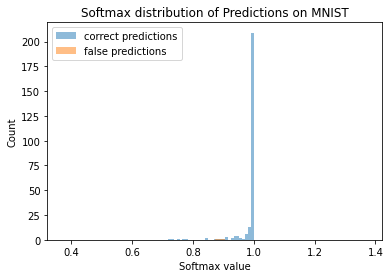

In [21]:
plot_softmax_hist(indices=mnist_indices,values=mnist_values,y=real_vals_mnist,dataset="MNIST")

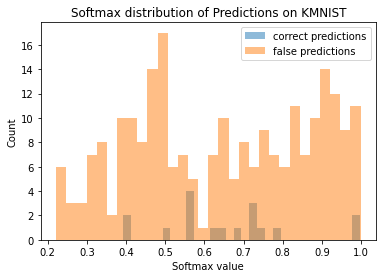

In [22]:
plot_softmax_hist(indices=kmnist_indices,values=kmnist_values,y=real_vals_kmnist,dataset="KMNIST")

## Let's compare the predictions on known data and unknown data!

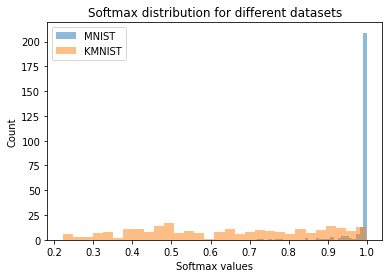

In [23]:
plt.hist(mnist_values.cpu().numpy(),alpha = 0.5, label="MNIST",bins=30)
plt.hist(kmnist_values.cpu().numpy(),alpha = 0.5, label="KMNIST",bins=30)
plt.legend()
plt.xlabel("Softmax values")
plt.ylabel("Count")
plt.title("Softmax distribution for different datasets")
plt.show()

# How can we fix this?
- https://arxiv.org/abs/1812.04606
- https://github.com/hendrycks/outlier-exposure
- Have fun :-)

# Adversarial Attacks
- https://arxiv.org/abs/1412.6572

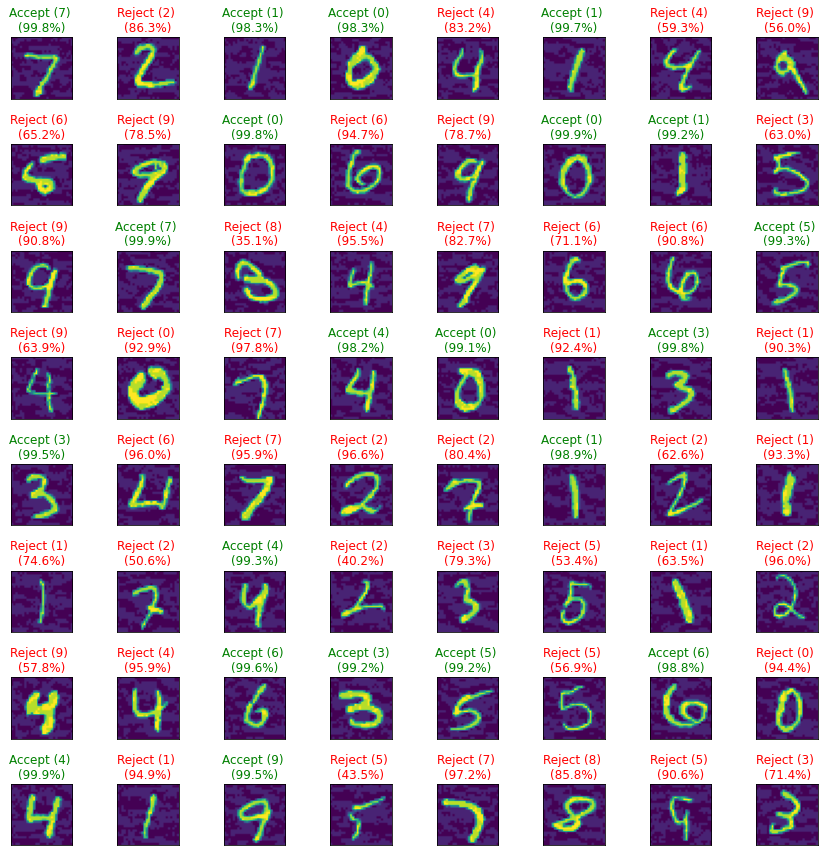

In [24]:
attack_fgsm = torchattacks.FGSM(model=model,eps=0.1)

model.eval()

for mnist_images, y in mnist_test_loader:
    #with torch.no_grad(): -> we need the gradient!
    perturbed_images= attack_fgsm(mnist_images,labels=y)
    y_hat = model(perturbed_images.to(device))
    break

mnist_values, mnist_indices = y_hat.softmax(dim=1).max(dim=1)
real_vals_mnist = y

# Softmax Thresholding
threshold = 0.98
new_labels = ["Accept" if c > threshold else "Reject" for c in mnist_values]
colors = ["green" if c > threshold else "red" for c in mnist_values]

fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()

for i in range(64):
    axs[i].imshow(to_pil_image(perturbed_images[i]))
    #axs[i].set_title(f"{mnist_indices[i]} ({mnist_values[i]:.1%})")
    axs[i].set_title(f"{new_labels[i]} ({mnist_indices[i]}) \n({mnist_values[i]:.1%})")
    axs[i].title.set_color(colors[i])
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)
    
plt.tight_layout()
plt.show()

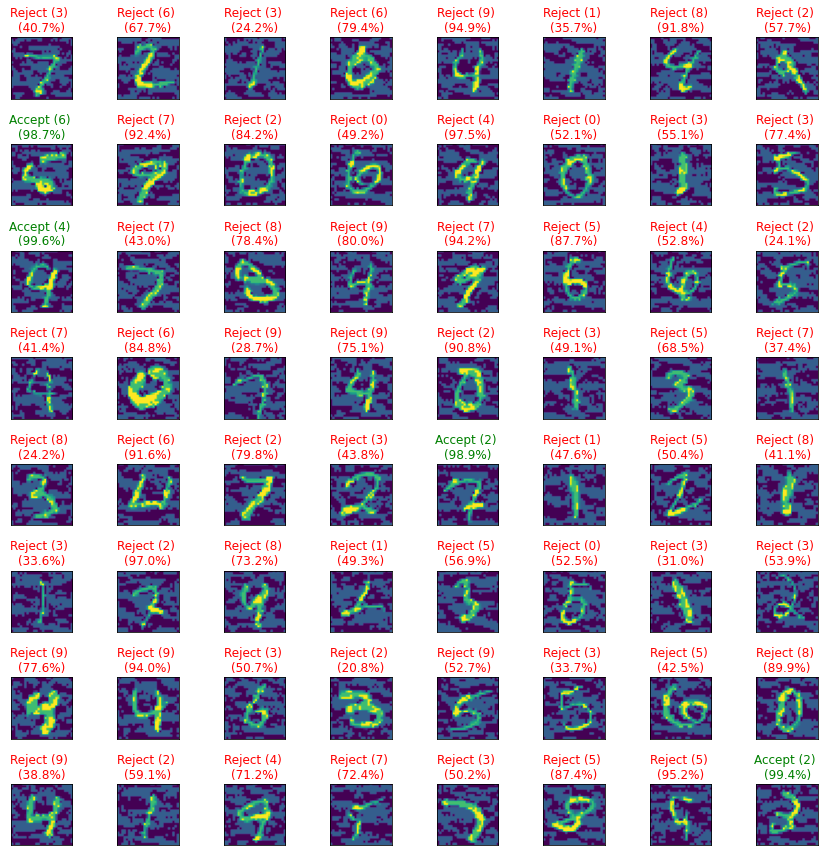

In [25]:
attack_fgsm = torchattacks.FGSM(model=model,eps=0.3)

model.eval()

for mnist_images, y in mnist_test_loader:
    #with torch.no_grad(): -> we need the gradient!
    perturbed_images= attack_fgsm(mnist_images,labels=y)
    y_hat = model(perturbed_images.to(device))
    break

mnist_values, mnist_indices = y_hat.softmax(dim=1).max(dim=1)
real_vals_mnist = y

# Softmax Thresholding
threshold = 0.98
new_labels = ["Accept" if c > threshold else "Reject" for c in mnist_values]
colors = ["green" if c > threshold else "red" for c in mnist_values]

fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()

for i in range(64):
    axs[i].imshow(to_pil_image(perturbed_images[i]))
    #axs[i].set_title(f"{mnist_indices[i]} ({mnist_values[i]:.1%})")
    axs[i].set_title(f"{new_labels[i]} ({mnist_indices[i]}) \n({mnist_values[i]:.1%})")
    axs[i].title.set_color(colors[i])
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)
    
plt.tight_layout()
plt.show()

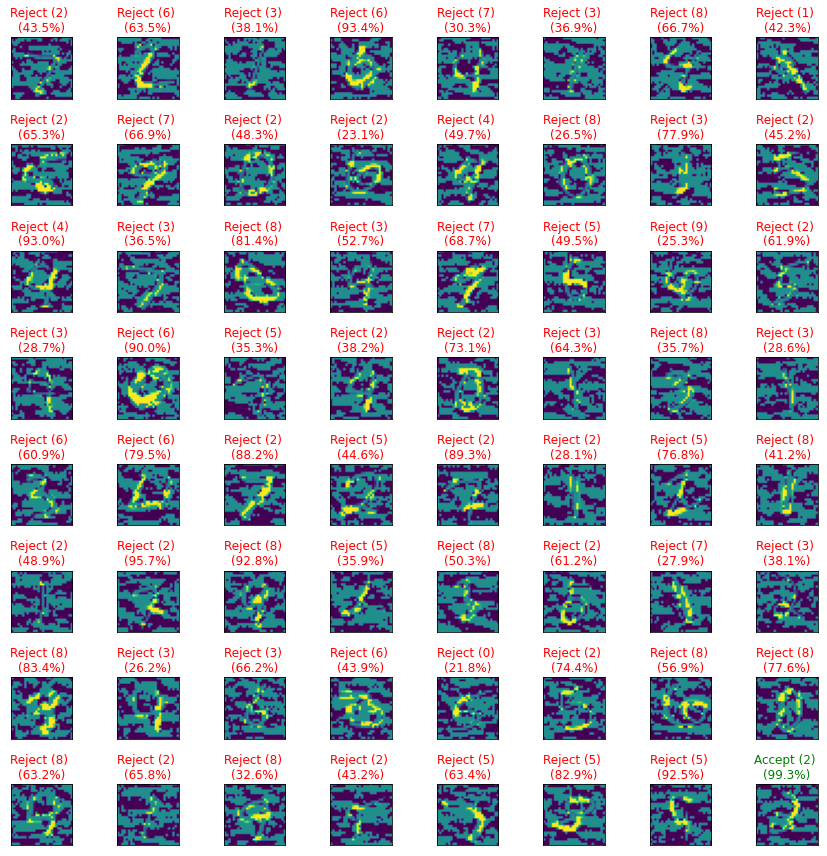

In [26]:
attack_fgsm = torchattacks.FGSM(model=model,eps=0.5)

model.eval()

for mnist_images, y in mnist_test_loader:
    #with torch.no_grad(): -> we need the gradient!
    perturbed_images= attack_fgsm(mnist_images,labels=y)
    y_hat = model(perturbed_images.to(device))
    break

mnist_values, mnist_indices = y_hat.softmax(dim=1).max(dim=1)
real_vals_mnist = y

# Softmax Thresholding
threshold = 0.98
new_labels = ["Accept" if c > threshold else "Reject" for c in mnist_values]
colors = ["green" if c > threshold else "red" for c in mnist_values]

fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()

for i in range(64):
    axs[i].imshow(to_pil_image(perturbed_images[i]))
    #axs[i].set_title(f"{mnist_indices[i]} ({mnist_values[i]:.1%})")
    axs[i].set_title(f"{new_labels[i]} ({mnist_indices[i]}) \n({mnist_values[i]:.1%})")
    axs[i].title.set_color(colors[i])
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)
    
plt.tight_layout()
plt.show()

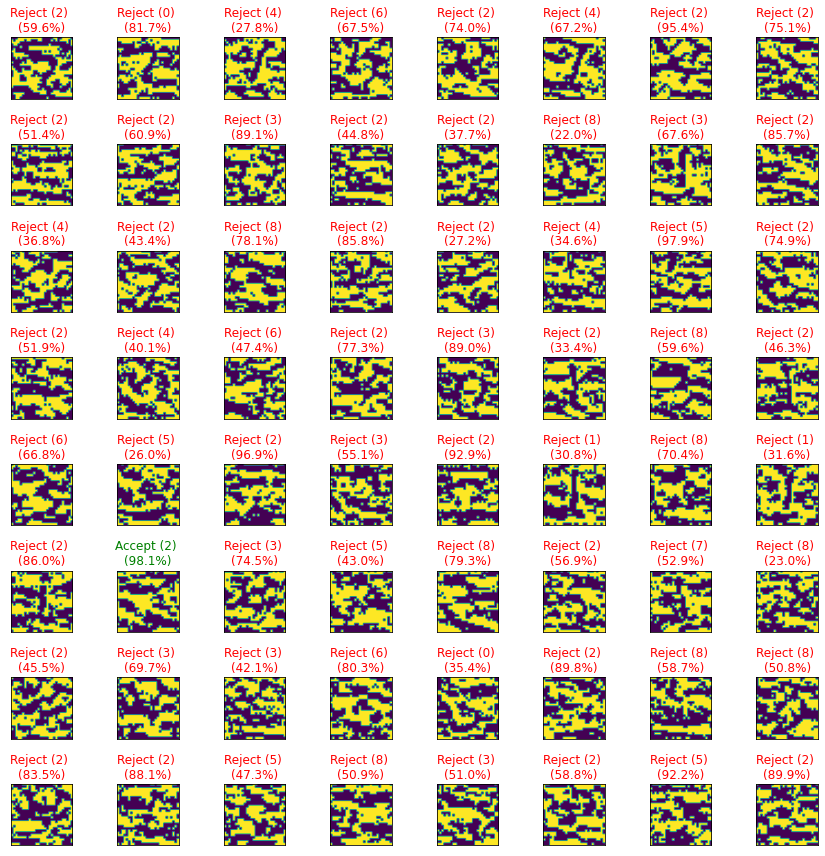

In [27]:
attack_fgsm = torchattacks.FGSM(model=model,eps=1)

model.eval()

for mnist_images, y in mnist_test_loader:
    #with torch.no_grad(): -> we need the gradient!
    perturbed_images= attack_fgsm(mnist_images,labels=y)
    y_hat = model(perturbed_images.to(device))
    break

mnist_values, mnist_indices = y_hat.softmax(dim=1).max(dim=1)
real_vals_mnist = y

# Softmax Thresholding
threshold = 0.98
new_labels = ["Accept" if c > threshold else "Reject" for c in mnist_values]
colors = ["green" if c > threshold else "red" for c in mnist_values]

fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()

for i in range(64):
    axs[i].imshow(to_pil_image(perturbed_images[i]))
    #axs[i].set_title(f"{mnist_indices[i]} ({mnist_values[i]:.1%})")
    axs[i].set_title(f"{new_labels[i]} ({mnist_indices[i]}) \n({mnist_values[i]:.1%})")
    axs[i].title.set_color(colors[i])
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)
    
plt.tight_layout()
plt.show()

In [28]:
epsis = [el/10 for el in range(15)]

In [29]:
model.eval()
accs = []
for eps in epsis:
    attack_fgsm = torchattacks.FGSM(model=model,eps=eps)
    preds = []
    targets = []
    for mnist_images, y in mnist_test_loader:
        #with torch.no_grad(): -> we need the gradient!
        perturbed_images= attack_fgsm(mnist_images,labels=y)
        y_hat = model(perturbed_images.to(device))
        _,prediction_indices = y_hat.softmax(dim=1).max(dim=1)
        preds.append([el.item() for el in prediction_indices])
        targets.append(y)
    
    correct = []

    for x,y in zip(preds,targets):
        for i in range(len(y)):
            if y.cpu().numpy()[i] == x[i]:
                correct.append(i)
    accs.append(len(correct)/len(mnist_test_loader.dataset))
    #print(f"The model achieved an accuracy of {len(correct)/len(mnist_test_loader.dataset)}!")


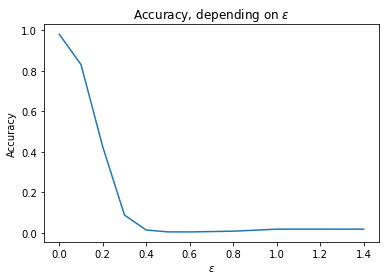

In [30]:
plt.plot(epsis,accs)
plt.xlabel("$\epsilon$")
plt.ylabel("Accuracy")
plt.title("Accuracy, depending on $\epsilon$")
plt.show()